# Introduction

이 노트는 포르투 세구로 대회 자료에서 소개부터 시작합니다. 그런 다음 교차 검증 및 쌓기를 사용하여 몇 가지 예측 모형을 준비하고 실행하고 제출을 준비합니다.


# Analysis packages


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

!pip install lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

# Load the data


In [32]:
trainset = pd.read_csv('./train.csv')
testset = pd.read_csv('./test.csv')

# Few quick observations

We can make few observations based on the data description in the competition:

- Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field;
- The postfix bin is used for binary features;
- The postfix cat to is used for categorical features;
- Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);
- A missing value is indicated by -1;
- The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
- id is a data input ordinal number.

Let's glimpse the data to see if these interpretations are confirmed.



In [33]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Indeed, we can observe the cat values are categorical, integer values ranging from 0 to n, bin values are binary (either 0 or 1).

Let's see how many rows and columns are in the data.



In [34]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


훈련 데이터 세트에는 59개의 열이 있으며 테스트 데이터 세트에는 58개만 있습니다. 
이 데이터 집합에서 target을 추출했어야 하므로, 이것은 괜찮아 보입니다. 
모든 것이 정상인지 확인하기 위해 두 데이터 세트에 설정된 열의 차이를 확인하겠습니다.


In [35]:
print("Columns in train and not in test dataset:",set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


# Introduction of metadata

데이터 조작을 쉽게 하기 위해, 우리는 몇 가지 메타 정보를 훈련 집합의 변수와 연관시킬 것입니다. 
이를 통해 분석, 검사 또는 모델링을 위한 다양한 유형의 피쳐를 쉽게 선택할 수 있습니다.
우리는 car, ind, reg 및 calc 유형의 특징에 대한 카테고리 필드도 사용하고 있습니다.

What metadata will be used:

- use: input, ID, target
- type: nominal, interval(real), ordinal(integer), binary
- preserve: True or False
- dataType: int, float, char
- category: ind, reg, car, calc


In [36]:
data = []
for feature in trainset.columns:
    dtype = trainset[feature].dtype
    
    if 'bin' in feature:
        type = 'binary'
    elif 'cat' in feature:
        type = 'categorical'
    elif trainset[feature].dtype == float:
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'
        
    feature_dict = {
        'varname' : feature,
        'dtype' : dtype,
        'type' : type
    }
    data.append(feature_dict)
    #print(data)
    
metadata = pd.DataFrame(data, columns = ['varname', 'dtype', 'type'])
metadata.set_index('varname', inplace=True)
metadata

,dtype,type
varname,,
id,int64,binary
target,int64,binary
ps_ind_01,int64,binary
ps_ind_02_cat,int64,categorical
ps_ind_03,int64,categorical
ps_ind_04_cat,int64,categorical
ps_ind_05_cat,int64,categorical
ps_ind_06_bin,int64,binary
ps_ind_07_bin,int64,binary


In [53]:
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif np.issubdtype(trainset[feature].dtype, np.floating):
        type = 'real'
    elif np.issubdtype(trainset[feature].dtype, np.integer):
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


We can extract, for example, all categorical values:



In [54]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

고유한 범주의 값이 몇 개인지 확인하기 위해 모든 기능을 검사하겠습니다.


In [55]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [56]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


There are one nominal feature (the id), 20 binary values, 21 real (or float numbers), 16 categorical features - all these being as well input values and one target value, which is as well binary, the target.



# Data analysis and statistics

## Target variable


<Figure size 432x288 with 0 Axes>

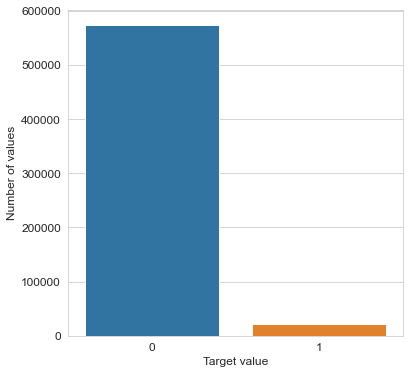

In [57]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

target 데이터의 3.64%만 target value = 1입니다. 
이는 train 데이터 세트가 매우 불균형하다는 것을 의미합니다. 
target = 0인 레코드의 언더샘플링을 하거나 대상 = 1인 레코드를 오버샘플링할 수 있습니다. 
데이터 세트가 크므로 대상 = 0인 레코드의 언더샘플링을 수행합니다.


## Real features


In [58]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [59]:
trainset['ps_car_12']

0         0.400000
1         0.316228
2         0.316228
3         0.374166
4         0.316070
            ...   
595207    0.374166
595208    0.387298
595209    0.397492
595210    0.374166
595211    0.400000
Name: ps_car_12, Length: 595212, dtype: float64

In [60]:
(pow(trainset['ps_car_12']*10, 2)).head(10) # pow : n승

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [61]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### Features with missing values
ps_reg_o3, ps_car_12, ps_car_14 have missing values (their minimum value is -1)

### Registration features
ps_reg_01 및 ps_reg_02는 분모가 10인 분수입니다(0.1, 0.2, 0.3).

### Car features
ps_car_12는 근삿값 제곱근을 자연수의 10으로 나눈 값인 반면 ps_car_15는 자연수의 제곱근입니다. 쌍 그림을 사용하여 값을 표현해 보겠습니다.



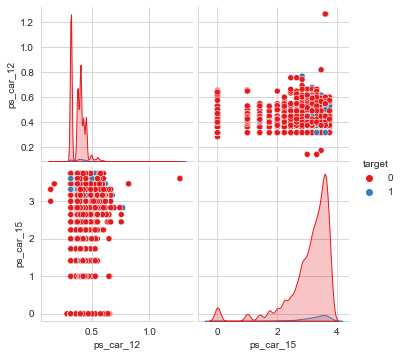

In [62]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### Calculated features

기능 ps_calc_01, ps_calc_02 및 ps_calc_03은 분포가 매우 유사하며 최대값이 0.9 모두에 해당하므로 일종의 비율일 수 있습니다. 다른 계산된 값은 최대값인 정수(5,6,7, 10,12)를 갖습니다.


C:\Users\HOME\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecat

<Figure size 432x288 with 0 Axes>

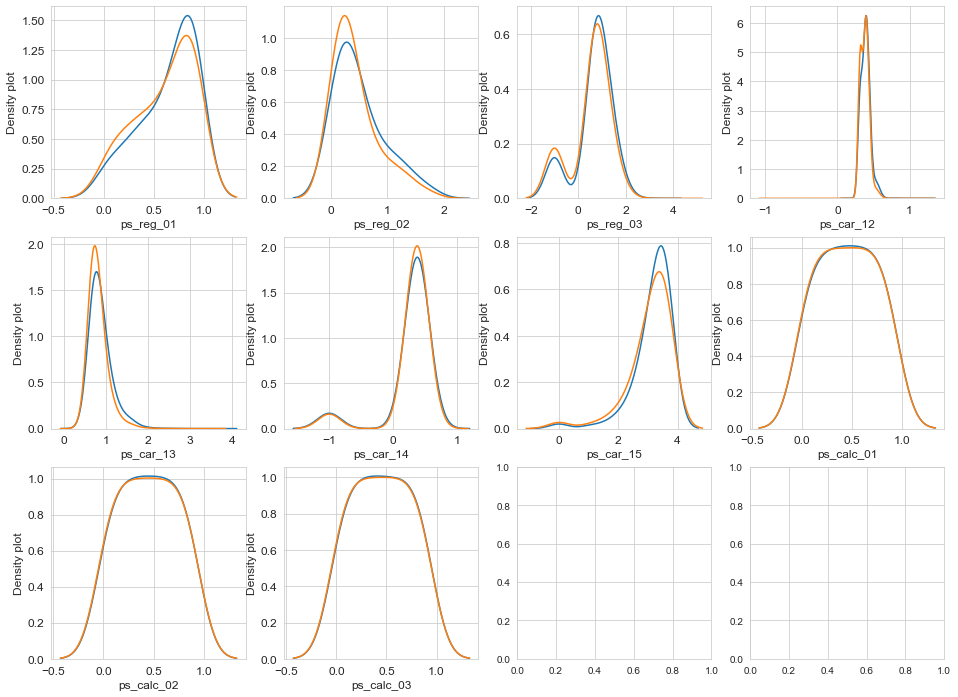

In [63]:
# 인덱스
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

# 백그라운드
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16,12))

# 그림
for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show();

ps_reg_02, ps_car_13, ps_car_15는 대상=0 및 대상=1과 관련된 값 집합 간에 가장 다른 분포를 보여줍니다.


real feature 간의 상관 관계를 시각화해 보겠습니다.


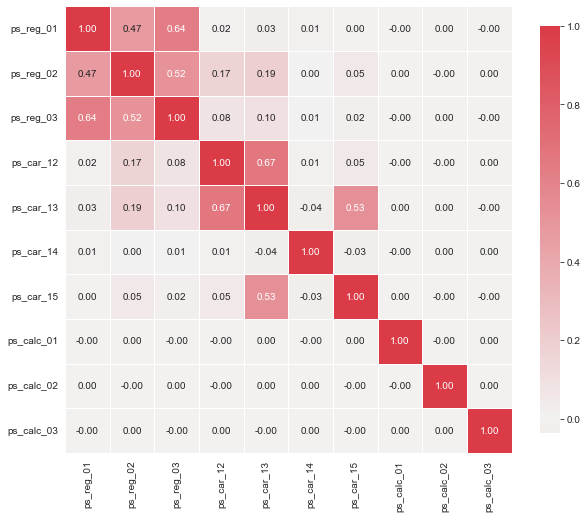

In [71]:
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

Let's visualize the plots of the variables with strong correlations. These are:

- ps_reg_01 with ps_reg_02 (0.47);
- ps_reg_01 with ps_reg_03 (0.64);
- ps_reg_02 with ps_reg_03 (0.52);
- ps_car_12 with ps_car_13 (0.67);
- ps_car_13 with ps_car_15 (0.53);

To show the pairs of values that are correlated we use pairplot. Before representing the pairs, we subsample the data, using only 2% in the sample.



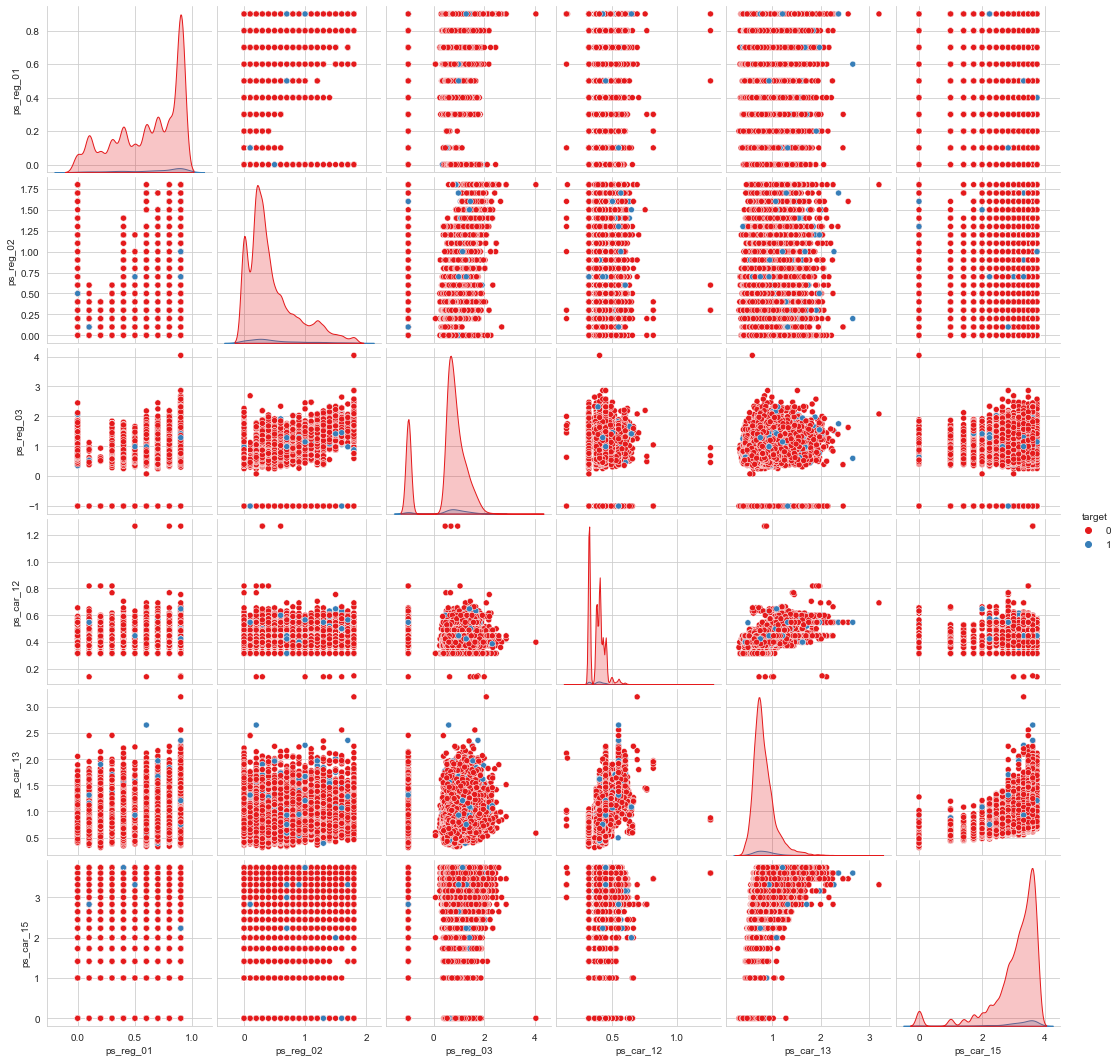

In [72]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()